In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo6.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo6.jpg


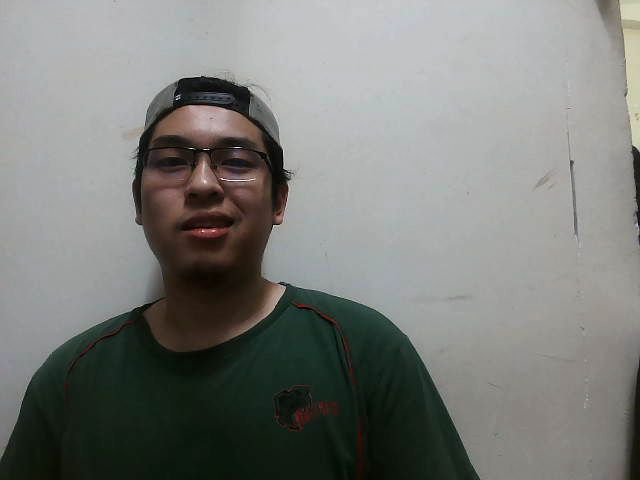

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
cd "/content/gdrive/MyDrive/Colab Notebooks"

/content/gdrive/MyDrive/Colab Notebooks


In [ ]:
import PIL
import io
import cv2
import numpy as np
from base64 import b64decode, b64encode
import matplotlib.pyplot as plt

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
path = '/content/gdrive/MyDrive/Colab Notebooks/'

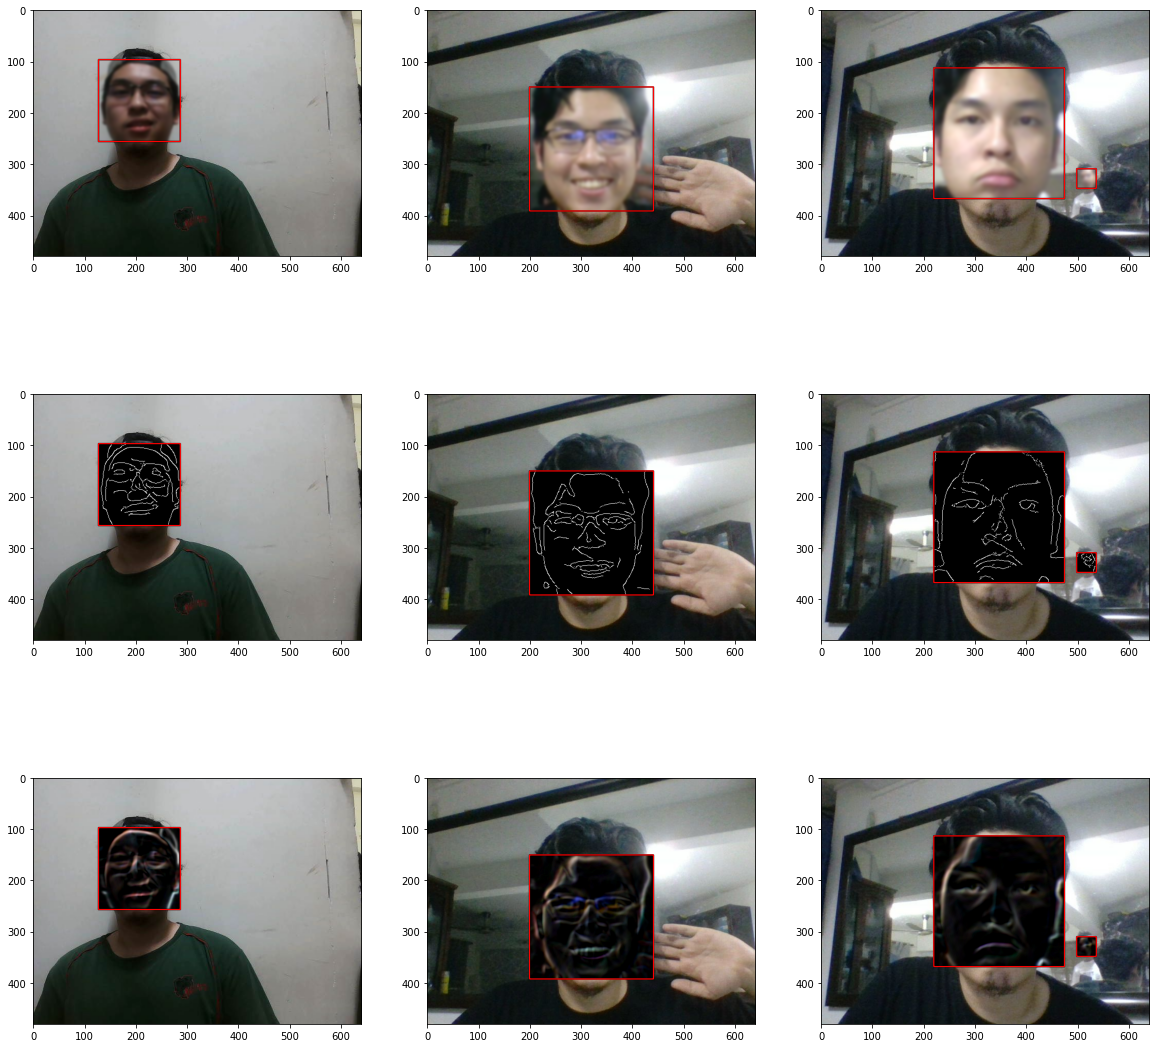

In [ ]:
# Face Detection + Gaussion Blur on Detected Face

bbox = ''
img_converted, gray, faces, img_canny, img_sobel = [], [], [], [], []
img = [cv2.imread(path+"photo6.jpg"), cv2.imread(path+"photo2.jpg"), cv2.imread(path+"photo3.jpg")]

# create transparent overlay for bounding box
bbox_array1 = np.zeros([480,640,4], dtype=np.uint8)
bbox_array2 = np.zeros([480,640,4], dtype=np.uint8)
bbox_array3 = np.zeros([480,640,4], dtype=np.uint8)

# convert image to Gray
for j in img:
  gray.append(cv2.cvtColor(j, cv2.COLOR_RGB2GRAY))

# convert BGR to RGB
for i in img:
  img_converted.append(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))

# get face region coordinates
for k in img_converted:
  faces.append(face_cascade.detectMultiScale(k))

for m in img_converted:
  img_canny.append(m.copy())
  img_sobel.append(m.copy())

for (x,y,w,h) in faces[0]:
  bbox_array1 = cv2.rectangle(bbox_array1,(x,y),(x+w,y+h),(255,0,0),2)
  detected_region1 = img_converted[0][y:y+h, x:x+w]

  # Gaussian Blur
  blur1 = cv2.GaussianBlur(detected_region1, (15, 15), 2.2)
  img_converted[0][y:y+h, x:x+w] = blur1

  # Canny
  canny1 = cv2.Canny(blur1 ,30, 70)
  canny1 = canny1.reshape((canny1.shape[0], canny1.shape[1], 1))  # Reshape from 2D to 3D array
  img_canny[0][y:y+h, x:x+w] = canny1

  # Sobel
  sobelx_1 = cv2.Sobel(blur1, cv2.CV_8U,1,0,ksize=3)
  sobely_1 = cv2.Sobel(blur1, cv2.CV_8U,0,1,ksize=3)
  imgSobel_1 = sobelx_1 + sobely_1
  img_sobel[0][y:y+h, x:x+w] = imgSobel_1

for (x,y,w,h) in faces[1]:
  bbox_array2 = cv2.rectangle(bbox_array2,(x,y),(x+w,y+h),(255,0,0),2)
  detected_region2 = img_converted[1][y:y+h, x:x+w]

  # Gaussion Blur
  blur2 = cv2.GaussianBlur(detected_region2, (15, 15), 2.6)
  img_converted[1][y:y+h, x:x+w] = blur2

  # Canny
  canny2 = cv2.Canny(blur2,30, 70)
  canny2 = canny2.reshape((canny2.shape[0], canny2.shape[1], 1))  # Reshape from 2D to 3D array
  img_canny[1][y:y+h, x:x+w] = canny2

  # Sobel
  sobelx_2 = cv2.Sobel(blur2, cv2.CV_8U,1,0,ksize=3)
  sobely_2 = cv2.Sobel(blur2, cv2.CV_8U,0,1,ksize=3)
  imgSobel_2 = sobelx_2 + sobely_2
  img_sobel[1][y:y+h, x:x+w] = imgSobel_2

for (x,y,w,h) in faces[2]:
  bbox_array3 = cv2.rectangle(bbox_array3,(x,y),(x+w,y+h),(255,0,0),2)
  detected_region3 = img_converted[2][y:y+h, x:x+w]

  # Gaussion Blur
  blur3 = cv2.GaussianBlur(detected_region3, (15, 15), 3)
  img_converted[2][y:y+h, x:x+w] = blur3

  # Canny
  canny3 = cv2.Canny(blur3,30, 50)
  canny3 = canny3.reshape((canny3.shape[0], canny3.shape[1], 1))  # Reshape from 2D to 3D array
  img_canny[2][y:y+h, x:x+w] = canny3

  # Sobel
  sobelx_3 = cv2.Sobel(blur3, cv2.CV_8U,1,0,ksize=3)
  sobely_3 = cv2.Sobel(blur3, cv2.CV_8U,0,1,ksize=3)
  imgSobel_3 = sobelx_3 + sobely_3
  img_sobel[2][y:y+h, x:x+w] = imgSobel_3


bbox_array1[:,:,3] = (bbox_array1.max(axis = 2) > 0 ).astype(int) * 255
bbox_array2[:,:,3] = (bbox_array2.max(axis = 2) > 0 ).astype(int) * 255
bbox_array3[:,:,3] = (bbox_array3.max(axis = 2) > 0 ).astype(int) * 255


plt.figure(figsize=[20,20])

plt.subplot(331);plt.imshow(img_converted[0]);plt.imshow(bbox_array1)
plt.subplot(332);plt.imshow(img_converted[1]);plt.imshow(bbox_array2)
plt.subplot(333);plt.imshow(img_converted[2]);plt.imshow(bbox_array3)

plt.subplot(334);plt.imshow(img_canny[0]);plt.imshow(bbox_array1)
plt.subplot(335);plt.imshow(img_canny[1]);plt.imshow(bbox_array2)
plt.subplot(336);plt.imshow(img_canny[2]);plt.imshow(bbox_array3)

plt.subplot(337);plt.imshow(img_sobel[0]);plt.imshow(bbox_array1)
plt.subplot(338);plt.imshow(img_sobel[1]);plt.imshow(bbox_array2)
plt.subplot(339);plt.imshow(img_sobel[2]);plt.imshow(bbox_array3)
